In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                     | 0/60000 [00:00<?, ?it/s]

 11%|███████████▌                                                                                           | 6743/60000 [00:00<00:00, 67425.56it/s]

 22%|██████████████████████▉                                                                               | 13486/60000 [00:00<00:00, 67378.79it/s]

 34%|██████████████████████████████████▍                                                                   | 20224/60000 [00:00<00:00, 67196.49it/s]

 45%|█████████████████████████████████████████████▊                                                        | 26944/60000 [00:00<00:00, 65469.62it/s]

 56%|████████████████████████████████████████████████████████▉                                             | 33498/60000 [00:00<00:00, 61322.94it/s]

 66%|███████████████████████████████████████████████████████████████████▍                                  | 39671/60000 [00:00<00:00, 61414.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                        | 45840/60000 [00:00<00:00, 59844.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████             | 52388/60000 [00:00<00:00, 61555.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 59097/60000 [00:00<00:00, 63229.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 62751.53it/s]

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 6480/10000 [00:00<00:00, 64795.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 64832.77it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 s6mgguuk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-s6mgguuk:best, 409.57MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                       | 0/368 [00:00<?, ?it/s]

  0%|▎                                                                                                              | 1/368 [00:00<03:38,  1.68it/s]

  4%|███▉                                                                                                          | 13/368 [00:00<00:14, 24.46it/s]

  7%|███████▏                                                                                                      | 24/368 [00:00<00:08, 42.58it/s]

 10%|██████████▊                                                                                                   | 36/368 [00:00<00:05, 59.55it/s]

 13%|██████████████▎                                                                                               | 48/368 [00:01<00:04, 73.02it/s]

 16%|█████████████████▉                                                                                            | 60/368 [00:01<00:03, 84.36it/s]

 20%|█████████████████████▊                                                                                        | 73/368 [00:01<00:03, 96.07it/s]

 23%|█████████████████████████▍                                                                                   | 86/368 [00:01<00:02, 103.15it/s]

 27%|█████████████████████████████                                                                                | 98/368 [00:01<00:02, 106.17it/s]

 30%|████████████████████████████████▎                                                                           | 110/368 [00:01<00:02, 108.81it/s]

 33%|███████████████████████████████████▊                                                                        | 122/368 [00:01<00:02, 110.55it/s]

 36%|███████████████████████████████████████▎                                                                    | 134/368 [00:01<00:02, 112.03it/s]

 40%|██████████████████████████████████████████▊                                                                 | 146/368 [00:01<00:01, 113.33it/s]

 43%|██████████████████████████████████████████████▎                                                             | 158/368 [00:01<00:01, 113.47it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 170/368 [00:02<00:01, 113.43it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 182/368 [00:02<00:01, 113.86it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 194/368 [00:02<00:01, 113.99it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 206/368 [00:02<00:01, 114.31it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 218/368 [00:02<00:01, 113.77it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                        | 230/368 [00:02<00:01, 113.37it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 242/368 [00:02<00:01, 114.02it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 254/368 [00:02<00:01, 113.42it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 266/368 [00:02<00:00, 114.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 278/368 [00:03<00:00, 114.27it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 290/368 [00:03<00:00, 114.26it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 302/368 [00:03<00:00, 114.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 314/368 [00:03<00:00, 114.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 326/368 [00:03<00:00, 113.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 338/368 [00:03<00:00, 113.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 350/368 [00:03<00:00, 113.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 362/368 [00:03<00:00, 112.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 94.38it/s]

train - OK


  0%|                                                                                                                        | 0/92 [00:00<?, ?it/s]

  1%|█▏                                                                                                              | 1/92 [00:00<00:15,  5.92it/s]

 14%|███████████████▋                                                                                               | 13/92 [00:00<00:01, 56.09it/s]

 27%|██████████████████████████████▏                                                                                | 25/92 [00:00<00:00, 78.98it/s]

 40%|████████████████████████████████████████████▋                                                                  | 37/92 [00:00<00:00, 91.59it/s]

 53%|███████████████████████████████████████████████████████████                                                    | 49/92 [00:00<00:00, 98.78it/s]

 66%|████████████████████████████████████████████████████████████████████████▉                                     | 61/92 [00:00<00:00, 103.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                      | 73/92 [00:00<00:00, 106.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 85/92 [00:00<00:00, 108.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 84.72it/s]

val - OK


  0%|                                                                                                                        | 0/76 [00:00<?, ?it/s]

  1%|█▍                                                                                                              | 1/76 [00:00<00:12,  5.94it/s]

 17%|██████████████████▉                                                                                            | 13/76 [00:00<00:01, 56.91it/s]

 33%|████████████████████████████████████▌                                                                          | 25/76 [00:00<00:00, 81.00it/s]

 49%|██████████████████████████████████████████████████████                                                         | 37/76 [00:00<00:00, 94.79it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                     | 50/76 [00:00<00:00, 104.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████▏                  | 63/76 [00:00<00:00, 111.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 97.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 85.42it/s]

test InD - OK


  0%|                                                                                                                       | 0/559 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/559 [00:00<01:27,  6.37it/s]

  2%|██▎                                                                                                           | 12/559 [00:00<00:10, 53.52it/s]

  4%|████▌                                                                                                         | 23/559 [00:00<00:07, 74.77it/s]

  6%|██████▋                                                                                                       | 34/559 [00:00<00:06, 86.37it/s]

  8%|████████▊                                                                                                     | 45/559 [00:00<00:05, 93.63it/s]

 10%|███████████                                                                                                   | 56/559 [00:00<00:05, 98.52it/s]

 12%|█████████████                                                                                                | 67/559 [00:00<00:04, 101.71it/s]

 14%|███████████████▏                                                                                             | 78/559 [00:00<00:04, 104.11it/s]

 16%|█████████████████▎                                                                                           | 89/559 [00:00<00:04, 105.53it/s]

 18%|███████████████████▎                                                                                        | 100/559 [00:01<00:04, 106.88it/s]

 20%|█████████████████████▋                                                                                      | 112/559 [00:01<00:04, 108.47it/s]

 22%|███████████████████████▉                                                                                    | 124/559 [00:01<00:03, 110.03it/s]

 24%|██████████████████████████▎                                                                                 | 136/559 [00:01<00:03, 111.52it/s]

 26%|████████████████████████████▌                                                                               | 148/559 [00:01<00:03, 112.96it/s]

 29%|██████████████████████████████▉                                                                             | 160/559 [00:01<00:03, 114.36it/s]

 31%|█████████████████████████████████▏                                                                          | 172/559 [00:01<00:03, 114.75it/s]

 33%|███████████████████████████████████▌                                                                        | 184/559 [00:01<00:03, 115.33it/s]

 35%|█████████████████████████████████████▊                                                                      | 196/559 [00:01<00:03, 115.49it/s]

 37%|████████████████████████████████████████▍                                                                   | 209/559 [00:02<00:02, 118.08it/s]

 40%|██████████████████████████████████████████▋                                                                 | 221/559 [00:02<00:02, 118.64it/s]

 42%|█████████████████████████████████████████████▏                                                              | 234/559 [00:02<00:02, 120.58it/s]

 44%|███████████████████████████████████████████████▋                                                            | 247/559 [00:02<00:02, 121.62it/s]

 47%|██████████████████████████████████████████████████▏                                                         | 260/559 [00:02<00:02, 121.22it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 273/559 [00:02<00:02, 122.28it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 286/559 [00:02<00:02, 124.33it/s]

 53%|█████████████████████████████████████████████████████████▊                                                  | 299/559 [00:02<00:02, 123.85it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 312/559 [00:02<00:02, 117.88it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 324/559 [00:02<00:02, 113.71it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 336/559 [00:03<00:01, 113.28it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 348/559 [00:03<00:01, 112.93it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 360/559 [00:03<00:01, 111.56it/s]

 67%|███████████████████████████████████████████████████████████████████████▊                                    | 372/559 [00:03<00:01, 111.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 384/559 [00:03<00:01, 111.14it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 396/559 [00:03<00:01, 112.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 408/559 [00:03<00:01, 113.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 421/559 [00:03<00:01, 116.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 433/559 [00:03<00:01, 117.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 445/559 [00:04<00:00, 118.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 457/559 [00:04<00:00, 117.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 469/559 [00:04<00:00, 117.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 481/559 [00:04<00:00, 117.26it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 493/559 [00:04<00:00, 117.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 505/559 [00:04<00:00, 115.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 517/559 [00:04<00:00, 115.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 529/559 [00:04<00:00, 115.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 541/559 [00:04<00:00, 115.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 553/559 [00:04<00:00, 114.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:05<00:00, 108.92it/s]

test OoD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

 12%|█████████████                                                                                                | 12/100 [00:00<00:00, 112.73it/s]

 25%|███████████████████████████▎                                                                                 | 25/100 [00:00<00:00, 117.04it/s]

 37%|████████████████████████████████████████▎                                                                    | 37/100 [00:00<00:00, 117.90it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 49/100 [00:00<00:00, 117.99it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 61/100 [00:00<00:00, 118.02it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 74/100 [00:00<00:00, 119.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 87/100 [00:00<00:00, 121.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.19it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(23523, 3, 32, 32) (23523, 2048) (23523, 256) (23523, 5) (23523,)
(5881, 3, 32, 32) (5881, 2048) (5881, 256) (5881, 5) (5881,)
(4861, 3, 32, 32) (4861, 2048) (4861, 256) (4861, 5) (4861,)
(35735, 3, 32, 32) (35735, 2048) (35735, 256) (35735, 5) (35735,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 5)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


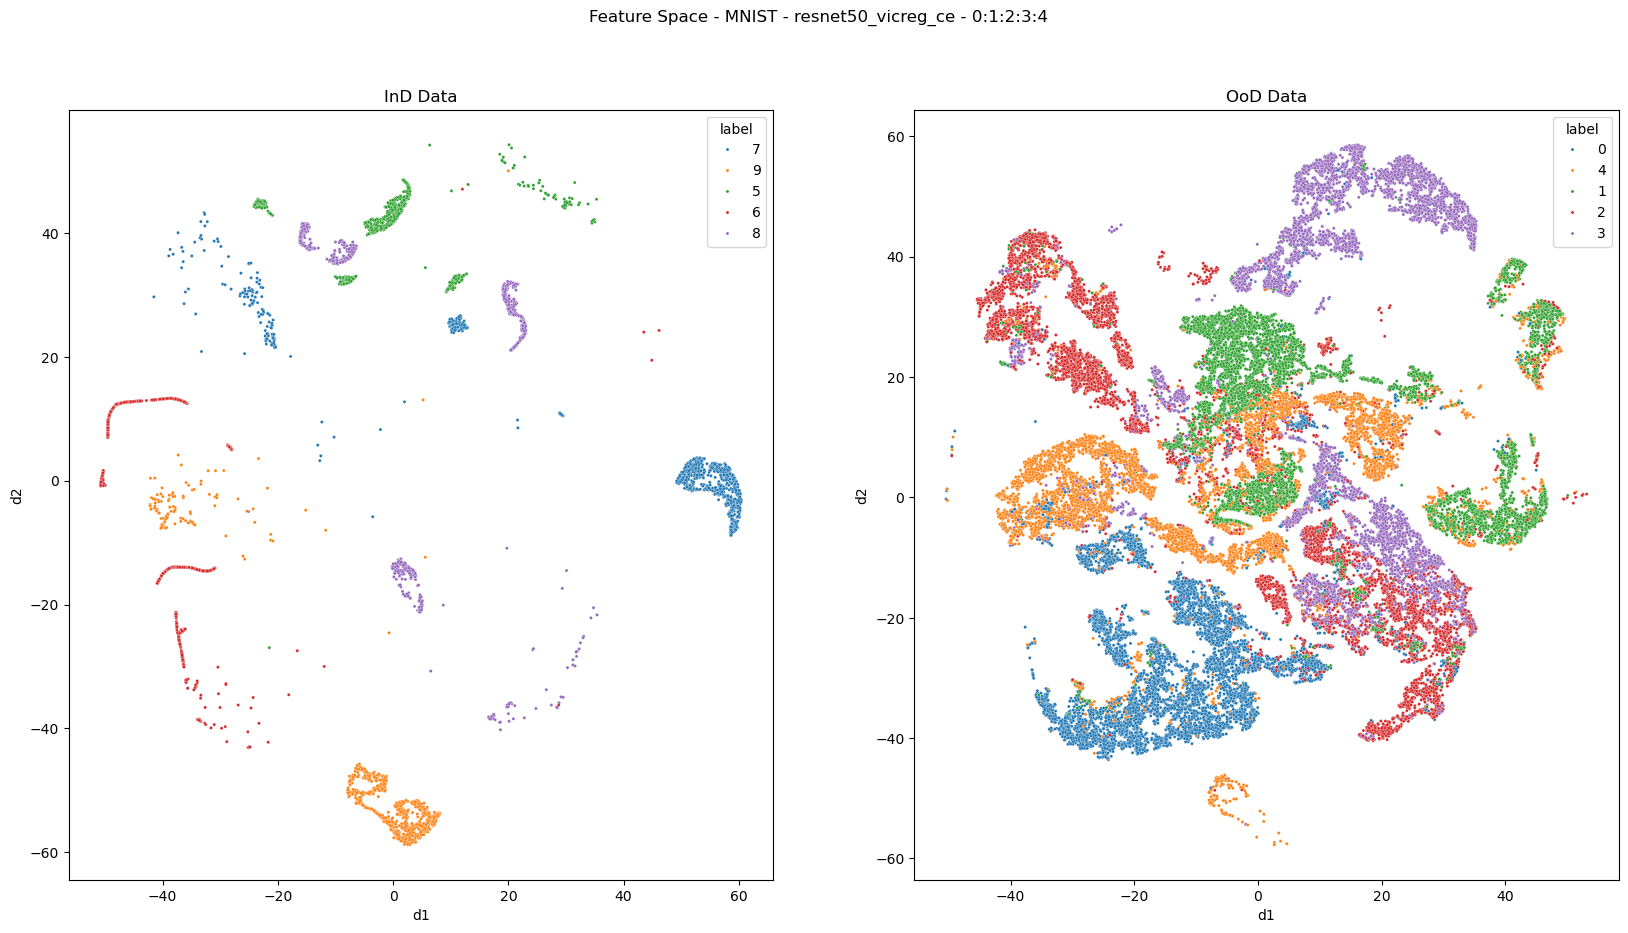

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

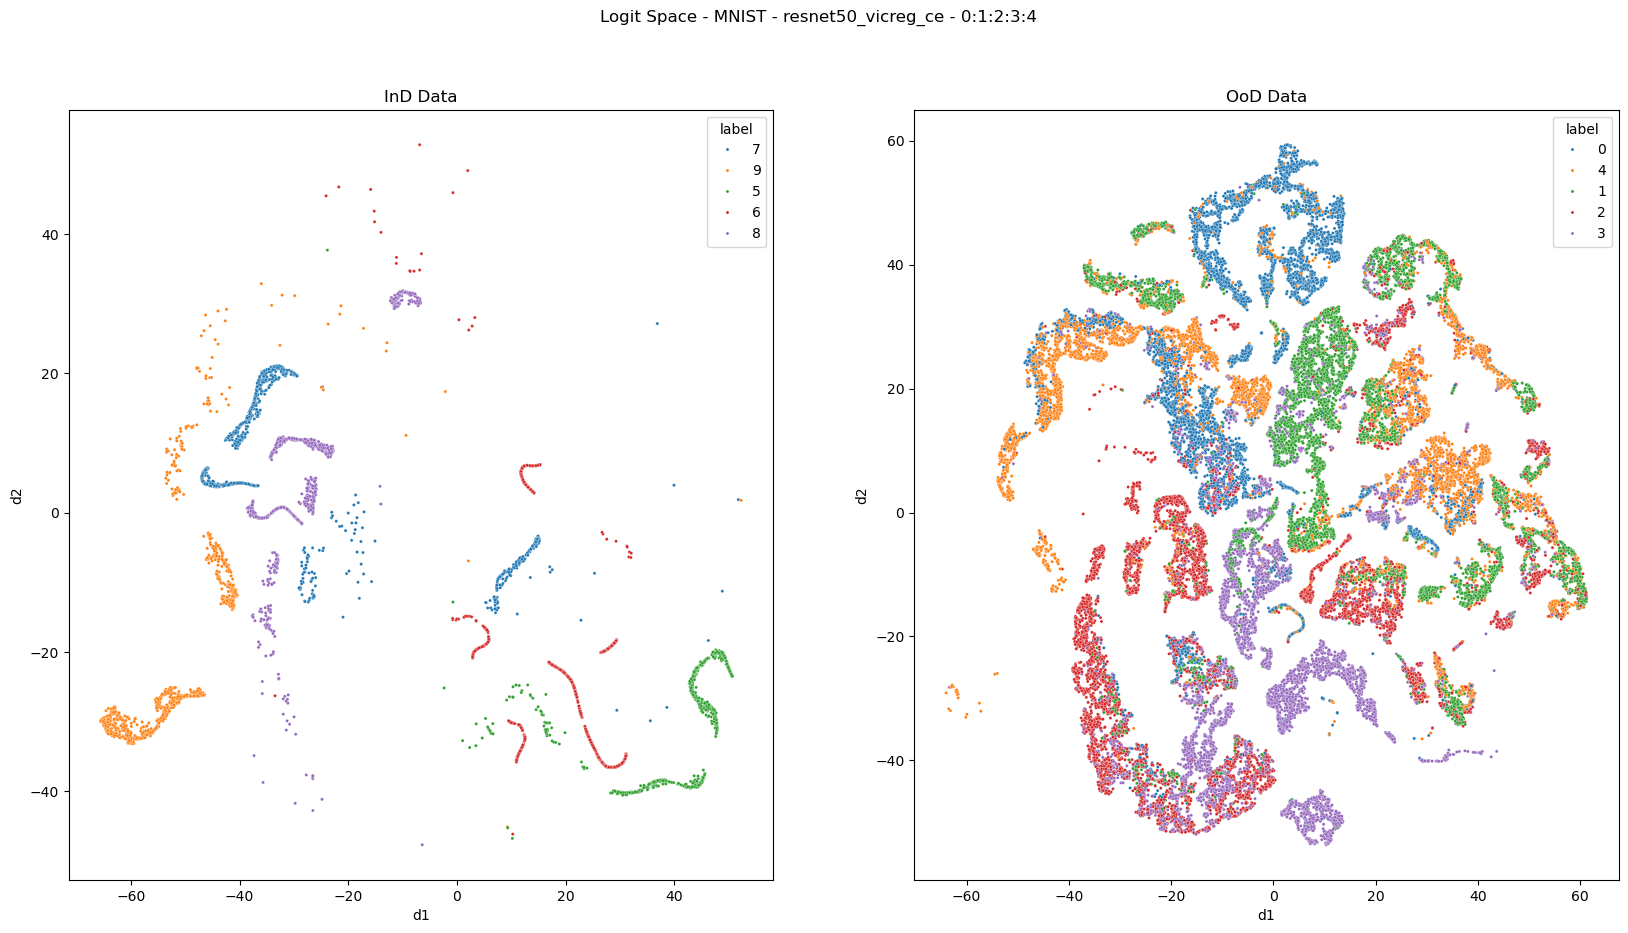

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:05<00:15,  5.05s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:10<00:10,  5.20s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:15<00:05,  5.18s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.21s/it]

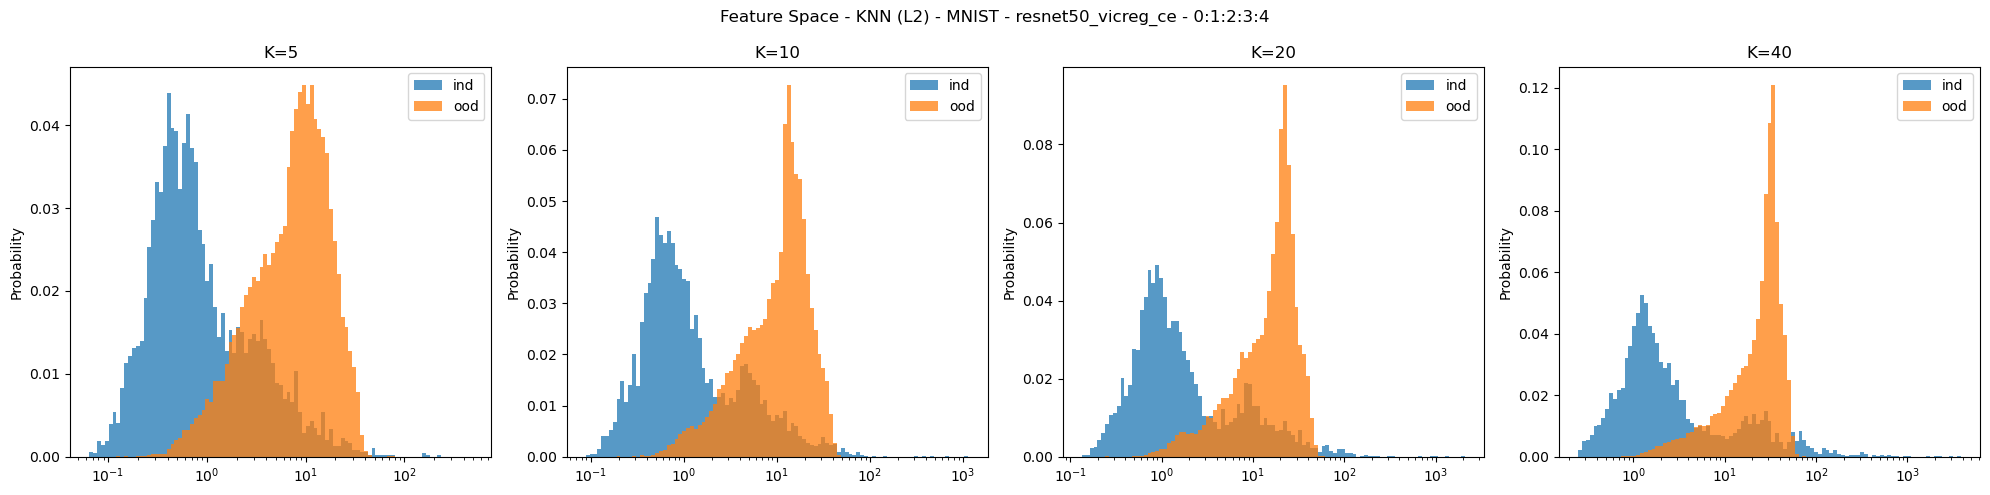

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:14,  4.89s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:09<00:09,  4.91s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:15<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]

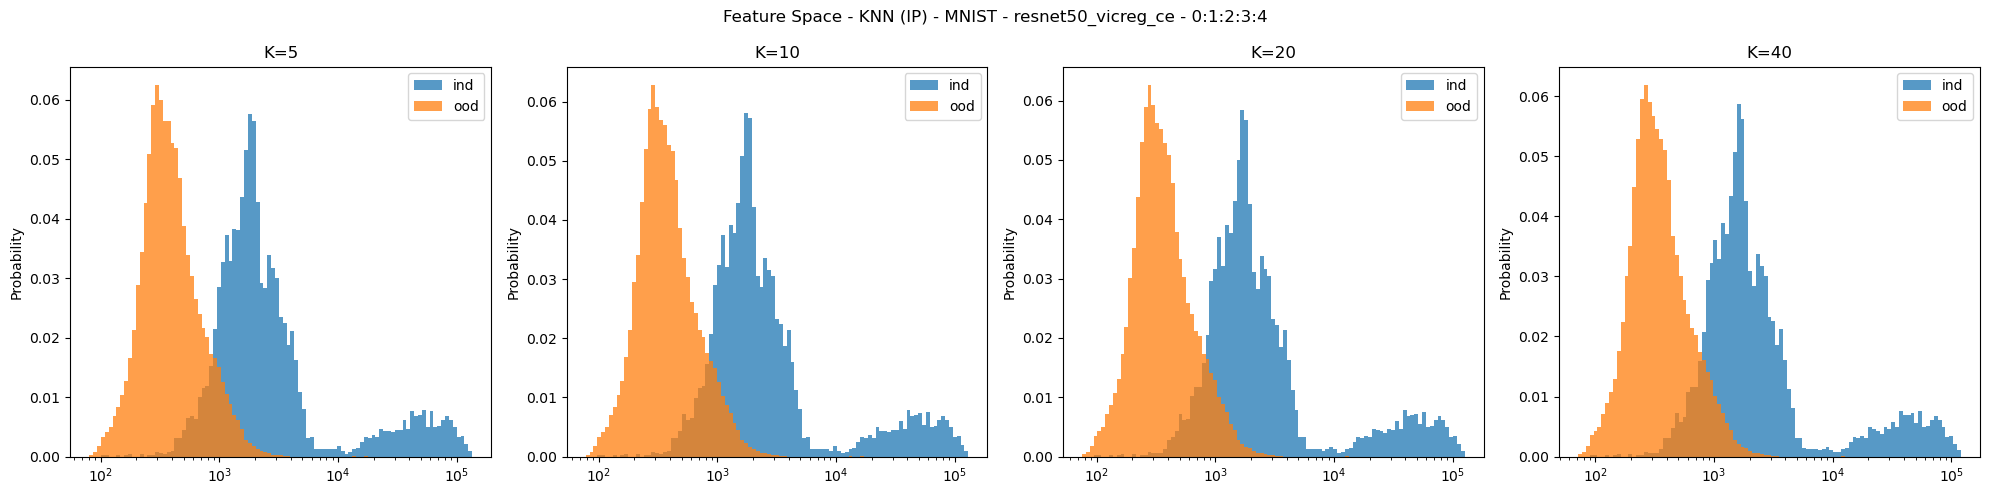

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:04<00:14,  4.90s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:09<00:09,  4.94s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:14<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.06s/it]

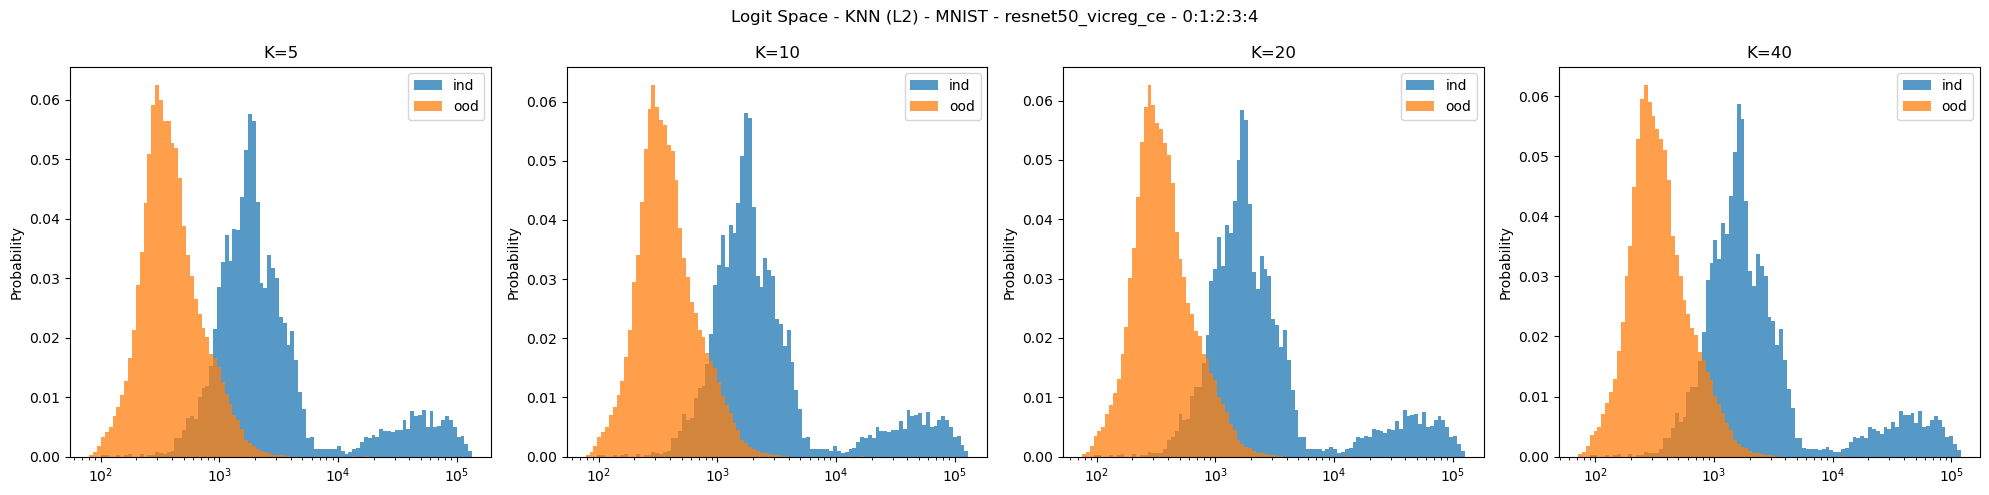

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:05<00:15,  5.33s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:10<00:10,  5.10s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:15<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

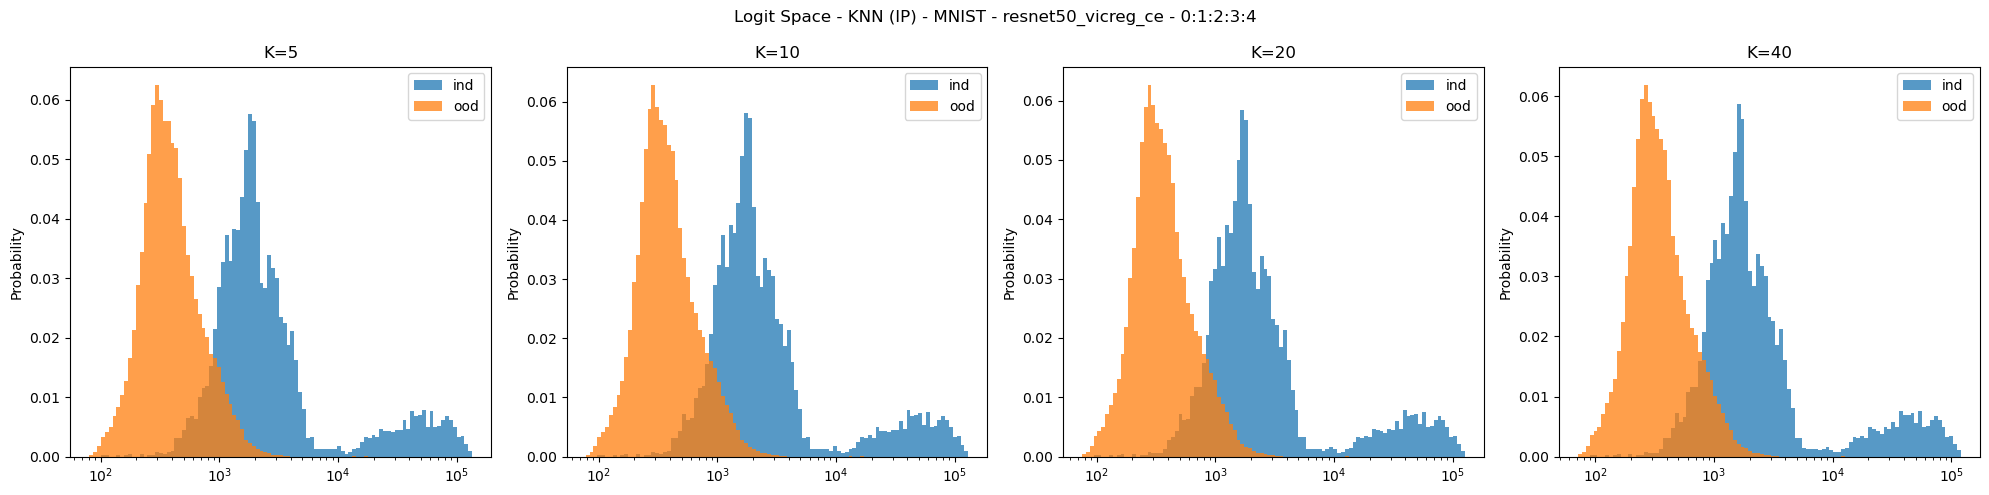

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_3725007/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3725007/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3725007/3659132256.py:6: RuntimeWarning: overflow encountered in exp
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_3725007/3659132256.py:6: RuntimeWarning: invalid value encountered in divide
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)


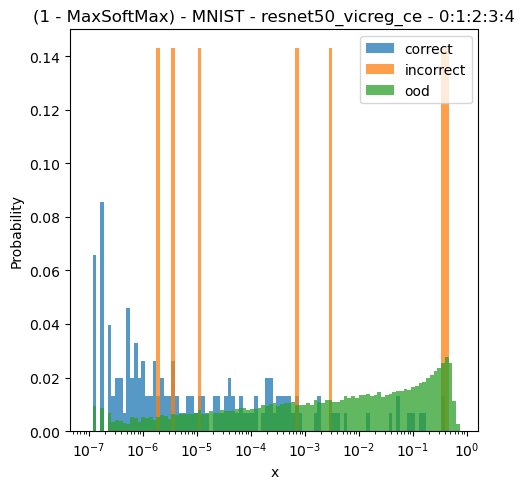

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()